<a href="https://colab.research.google.com/github/rahiakela/advanced-natural-language-processing-with-tensorflow-2/blob/main/3-named-entity-recognition/1_named_entity_recognition_with_BiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Named Entity Recognition with BiLSTM

One of the fundamental building blocks of NLU is **Named Entity Recognition
(NER)**. The names of people, companies, products, and quantities can be tagged in a piece of text with NER, which is very useful in chatbot applications and many other use cases in information retrieval and extraction.

Building and training a model capable of doing NER requires several techniques, such as **Conditional Random Fields (CRFs)** and **Bi-directional LSTMs(BiLSTMs)**.



## Named Entity Recognition

Given a sentence or a piece of text, the objective of an NER model is to locate and classify text tokens as named entities in categories such as people's names, organizations and companies, physical locations, quantities, monetary quantities, times, dates, and even protein or DNA sequences. 

NER should tag the following sentence:

```
Ashish paid Uber $80 to go to the Twitter offices in San Francisco.
```

as follows:

$$
[Ashish]_{PER} \space paid \space [Uber]_{ORG} \space [$80]_{MONEY} \space to \space go \space to \space the \space [Twitter]_{ORG} \space offices \space in \space [San Francisco]_{LOC}.
$$

The most common tags are listed in the table below:

| **Type** | Example Tag | Example |
|---|---|---|
| Person | PER | Gregory went to the castle. |
| Organization | ORG | WHO just issued an epidemic advisory.|
| Location | LOC | She lives in Seattle. |
| Money | MONEY | You owe me twenty dollars. |
| Percentage | PERCENT | Stocks have risen 10% today. |
| Date | DATE | Let's meet on Wednesday. |
| Time | TIME | Is it 5 pm already? |

There are different data sets and tagging schemes that can be used to train NER models. Different data sets will have different subsets of the tags.

There are a few different ways to build an NER model. If the sentence is considered a sequence, then this task can be modeled as a word-by-word labeling task.

Hence, models similar to the models used for Part of Speech (POS) tagging are applicable. Features can be added to a model to improve labeling. The POS of a word and its neighboring words are the most straightforward features to add. Word shape features that model lowercase letters can add a lot of information, principally because a lot of the entity types deal with proper nouns, such as those for people and organizations.

Another vital feature involves checking a word in a gazetteer. A gazetteer is like a database of important geographical entities.

## Setup

In [ ]:
!pip install tensorflow-addons

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import Model, Input, Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, TimeDistributed, Dense, Dropout
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

import numpy as np
import pandas as pd

import os
import csv
import collections
import glob
import matplotlib.pyplot as plt

tf.__version__

'2.5.0'

In [3]:
tfds.__version__

'4.0.1'

In [4]:
######## GPU CONFIGS FOR RTX 2070 ###############
## Please ignore if not training on GPU       ##
## this is important for running CuDNN on GPU ##

tf.keras.backend.clear_session() #- for easy reset of notebook state

# chck if GPU can be seen by TF
tf.config.list_physical_devices('GPU')
# only if you want to see how commands are executed, uncomment below
# tf.debugging.set_log_device_placement(True)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
###############################################

1 Physical GPUs, 1 Logical GPU


In [ ]:
%%shell

wget https://gmb.let.rug.nl/releases/gmb-2.2.0.zip

# !unzip -o gmb-2.2.0.zip  <= use the -o to expand and overwrite whtout prompting
unzip gmb-2.2.0.zip
rm -rf gmb-2.2.0.zip

## Loading the data

**The GMB data set**

With all the basics in the bag, we are ready to build a model that classifies NERs. For this task, the Groningen Meaning Bank (GMB) data set will be used. This dataset is not considered a gold standard.

Also note that since we are going to be working on large data sets, some of the following steps may take some time to execute. In the world of Natural Language Processing (NLP), more training data and training time is key to great results.

The data subfolder has a number of subfolders with different files. README supplied with the data set provides details about the various files and their contents. For this example, we will be using only files named en.tags in various subdirectories. These files are tab-separated files with
each word of a sentence in a row.

Out of lots of fields, we are going to use only the token and the named entity tag.

In [6]:
data_root = './gmb-2.2.0/data/'

fnames = []
for root, dirs, files in os.walk(data_root):
    for filename in files:
        if filename.endswith(".tags"):
            fnames.append(os.path.join(root, filename))

In [7]:
fnames[:2]

['./gmb-2.2.0/data/p08/d0059/en.tags', './gmb-2.2.0/data/p08/d0158/en.tags']

A few processing steps need to happen. Each file has a number of sentences, with each words in a row. The entire sentence as a sequence and the corresponding sequence of NER tags need to be fed in as inputs while training the model. As mentioned, the NER tags also need to be simplified to the top-level entities only. Secondly, the NER tags need to be converted to the IOB format. IOB stands for In-Other-Begin. These letters are used as a prefix to the NER tag. The sentence fragment in the table below shows how this scheme works:

```
Reverend Terry Jones arrived in New    York
B-per    I-per I-per O       O  B-geo  I-geo
```

Note that New York
is one location. As soon as New is encountered, it marks the start of the geo NER
tag, hence it is assigned B-geo. The next word is York, which is a continuation of
the same geographical entity. For any network, classifying the word New as the
start of the geographical entity is going to be very challenging. However, a BiLSTM
network would be able to see the succeeding words, which helps quite a bit with
disambiguation.



In [8]:
# First, create a directory to store all the processed files
!mkdir ner

We want to process the tags so that we strip the subcategories of the NER tags out. It would also be nice to collect some stats on the types of tags in the documents.

In [9]:
ner_tags = collections.Counter()
iob_tags = collections.Counter()


def strip_ner_subcat(tag):
  # NER tags are of form {cat}-{subcat} eg tim-dow. We only want first part
  return tag.split("-")[0]

The next method takes a sequence of tags and converts them into IOB format.

In [10]:
def iob_format(ners):
  # converts IO tags into IOB format
  # input is a sequence of IO NER tokens
  # convert this: O, PERSON, PERSON, O, O, LOCATION, O
  # into: O, B-PERSON, I-PERSON, O, O, B-LOCATION, O
  iob_tokens = []

  for idx, token in enumerate(ners):
    if token != "O":    # !other
      if idx == 0:
        token = "B-" + token  # start of sentence
      elif ners[idx - 1] == token:
        token = "I-" + token  # continues
      else:
        token = "B-" + token

    iob_tokens.append(token)
    iob_tags[token] += 1
  return iob_tokens

Once these two convenience functions are ready, all the tags files need to be read and processed.

In [ ]:
total_sentences = 0
outfiles = []

for idx, file in enumerate(fnames):
  with open(file, "rb") as content:
    data = content.read().decode("utf-8").strip()
    sentences = data.split("\n\n")
    print(idx, file, len(sentences))
    total_sentences += len(sentences)

    with open("./ner/" + str(idx) + "-" + os.path.basename(file), "w") as outfile:
      outfiles.append("./ner/" + str(idx) + "-" + os.path.basename(file))
      writer = csv.writer(outfile)

      for sentence in sentences:
        toks = sentence.split("\n")
        words, pos, ner = [], [], []
        for tok in toks:
          t = tok.split("\t")
          words.append(t[0])
          pos.append(t[1])
          ner_tags[t[3]] += 1
          ner.append(strip_ner_subcat(t[3]))
      
        writer.writerow([" ".join(words), " ".join(iob_format(ner)), " ".join(pos)])

Files are read and split into two empty newline characters. That is the marker
for the end of a sentence in the file. Only the actual words, POS tokens, and NER tokens are used from the file. Once these are collected, a new CSV file is written with three columns: the sentence, a sequence of POS tags, and a sequence of NER tags.

In [12]:
print("total number of sentences:", total_sentences)

total number of sentences: 62010


To confirm the distribution of the NER tags before and after processing.

In [13]:
print(ner_tags)
print(iob_tags)

Counter({'O': 1146068, 'geo-nam': 58388, 'org-nam': 48034, 'per-nam': 23790, 'gpe-nam': 20680, 'tim-dat': 12786, 'tim-dow': 11404, 'per-tit': 9800, 'per-fam': 8152, 'tim-yoc': 5290, 'tim-moy': 4262, 'per-giv': 2413, 'tim-clo': 891, 'art-nam': 866, 'eve-nam': 602, 'nat-nam': 300, 'tim-nam': 146, 'eve-ord': 107, 'per-ini': 60, 'org-leg': 60, 'per-ord': 38, 'tim-dom': 10, 'art-add': 1, 'per-mid': 1})
Counter({'O': 1146068, 'B-geo': 48876, 'B-tim': 26296, 'B-org': 26195, 'I-per': 22270, 'B-per': 21984, 'I-org': 21899, 'B-gpe': 20436, 'I-geo': 9512, 'I-tim': 8493, 'B-art': 503, 'B-eve': 391, 'I-art': 364, 'I-eve': 318, 'I-gpe': 244, 'B-nat': 238, 'I-nat': 62})


As is evident, some tags were very infrequent, like tim-dom. It would be next to impossible for a network to learn them. Aggregating up one level helps increase the signal for these tags.

In [14]:
labels, values = zip(*iob_tags.items())

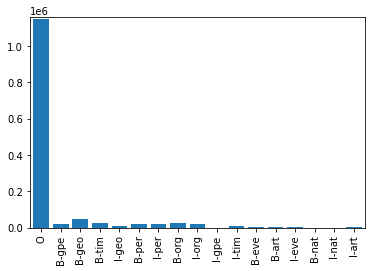

In [15]:
indexes = np.arange(len(labels))

plt.bar(indexes, values)
plt.xticks  (indexes, labels, rotation="vertical")
plt.margins(0.01)
plt.subplots_adjust(bottom=0.15)
plt.show()

## Normalizing and vectorizing data

For this, pandas and numpy methods will be used. The first step is to load the contents of the processed files into one DataFrame.

In [16]:
# could use `outfiles` param as well
files = glob.glob("./ner/*.tags")

data_pd = pd.concat([pd.read_csv(f, header=None, names=["text", "label", "pos"]) for f in files], ignore_index=True)

This step may take a while given that it is processing 10,000 files. Once the content is loaded, we can check the structure of the DataFrame:

In [17]:
data_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62010 entries, 0 to 62009
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    62010 non-null  object
 1   label   62010 non-null  object
 2   pos     62010 non-null  object
dtypes: object(3)
memory usage: 1.4+ MB


Both the text and NER tags need to be tokenized and encoded into numbers for
use in training. We are going to be using core methods provided by the keras.
preprocessing package. 

First, the tokenizer will be used to tokenize the text. In this example, the text only needs to be tokenized by white spaces, as it has been broken
up already:

In [18]:
text_token = Tokenizer(filters="[\\]^\t\n", lower=False, split=" ", oov_token="<OOV>")
pos_token = Tokenizer(filters="\t\n", lower=False, split=" ", oov_token="<OOV>")
ner_token = Tokenizer(filters="\t\n", lower=False, split=" ", oov_token="<OOV>")

text_token.fit_on_texts(data_pd["text"])
pos_token.fit_on_texts(data_pd["pos"])
ner_token.fit_on_texts(data_pd["label"])

The default values for the tokenizer are quite reasonable. However, in this particular case, it is important to only tokenize on spaces and not clean the special characters out. Otherwise the data will become mis-formatted.

This tokenizer has some useful features. It provides a way to restrict the size of the vocabulary by word counts, TF-IDF, and so on. If the num_words parameter is passed with a numeric value, the tokenizer will limit the number of tokens by word frequencies to that number. The fit_on_texts method takes in all the texts, tokenizes them, and constructs dictionaries with tokens that will be used later to tokenize and encode in one go. 

A convenience function, get_config(), can be called after the tokenizer has been fit on texts to provide information about the tokens:

In [19]:
ner_config = ner_token.get_config()
text_config = text_token.get_config()

print(ner_config)

{'num_words': None, 'filters': '\t\n', 'lower': False, 'split': ' ', 'char_level': False, 'oov_token': '<OOV>', 'document_count': 62010, 'word_counts': '{"O": 1146068, "B-org": 26195, "B-tim": 26296, "I-org": 21899, "B-geo": 48876, "I-tim": 8493, "B-gpe": 20436, "B-per": 21984, "I-per": 22270, "I-geo": 9512, "B-art": 503, "B-eve": 391, "I-eve": 318, "B-nat": 238, "I-gpe": 244, "I-nat": 62, "I-art": 364}', 'word_docs': '{"O": 61999, "B-tim": 22345, "B-org": 20478, "I-org": 11011, "I-tim": 5526, "B-geo": 31660, "B-gpe": 16565, "I-per": 13805, "I-geo": 7738, "B-per": 17499, "B-eve": 361, "I-eve": 201, "B-art": 425, "B-nat": 211, "I-gpe": 224, "I-nat": 50, "I-art": 207}', 'index_docs': '{"2": 61999, "4": 22345, "5": 20478, "8": 11011, "11": 5526, "3": 31660, "9": 16565, "6": 13805, "10": 7738, "7": 17499, "13": 361, "15": 201, "12": 425, "17": 211, "16": 224, "18": 50, "14": 207}', 'index_word': '{"1": "<OOV>", "2": "O", "3": "B-geo", "4": "B-tim", "5": "B-org", "6": "I-per", "7": "B-per",

The `index_word` dictionary property in the config provides a mapping between
IDs and tokens. There is a considerable amount of information in the config. The vocabularies can be obtained from the config:

In [20]:
text_vocab = eval(text_config["index_word"])
ner_vocab = eval(ner_config["index_word"])

print("Unique words in vocab:", len(text_vocab))
print("Unique NER tags in vocab:", len(ner_vocab))

Unique words in vocab: 39422
Unique NER tags in vocab: 18


Tokenizing and encoding text and named entity labels is quite easy:

In [55]:
x_token = text_token.texts_to_sequences(data_pd["text"])
y_token = ner_token.texts_to_sequences(data_pd["label"])

print(text_token.sequences_to_texts([x_token[1]]), data_pd["text"][1])
print(ner_token.sequences_to_texts([y_token[1]]), data_pd["label"][1])

['The job market looks better , with the Labor Department reporting the biggest drop since 2001 in requests for first-time unemployment compensation .'] The job market looks better , with the Labor Department reporting the biggest drop since 2001 in requests for first-time unemployment compensation .
['O O O O O O O O B-org I-org O O O O O B-tim O O O O O O O'] O O O O O O O O B-org I-org O O O O O B-tim O O O O O O O


Since sequences are of different sizes, they will all be padded or truncated to a size of 50 tokens.

In [22]:
max_len = 50

x_pad = sequence.pad_sequences(x_token, padding="post", maxlen=max_len)
y_pad = sequence.pad_sequences(y_token, padding="post", maxlen=max_len)

print(x_pad.shape, y_pad.shape)

(62010, 50) (62010, 50)


In [56]:
text_token.sequences_to_texts([x_pad[1]])

['The job market looks better , with the Labor Department reporting the biggest drop since 2001 in requests for first-time unemployment compensation . <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>']

In [57]:
ner_token.sequences_to_texts([y_pad[1]])

['O O O O O O O O B-org I-org O O O O O B-tim O O O O O O O <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>']

There is an additional step that needs to be performed on the labels. Since there are multiple labels, each label token needs to be one-hot encoded like so:

In [25]:
num_classes = len(ner_vocab) + 1

Y = tf.keras.utils.to_categorical(y_pad, num_classes=num_classes)
Y.shape

(62010, 50, 19)

## A BiLSTM model

The first model we will try is a BiLSTM model. 

First, the basic constants need to be set up:

In [26]:
# Length of the vocabulary
vocab_size = len(text_vocab) + 1

# The embedding dimension
embedding_dim = 64

# Number of RNN units
rnn_units = 100

# batch size
BATCH_SIZE = 90

# num of NER classes
num_classes = len(ner_vocab) + 1

Next, a convenience function for instantiating models is defined:

In [27]:
dropout = 0.2

def build_model_bilstm(vocab_size, embedding_dim, rnn_units, batch_size, classes):
  model = tf.keras.Sequential([
       Embedding(vocab_size, embedding_dim, mask_zero=True, batch_input_shape=[batch_size, None]),
       Bidirectional(LSTM(units=rnn_units, return_sequences=True, dropout=dropout, kernel_initializer=tf.keras.initializers.he_normal())),
       TimeDistributed(Dense(rnn_units, activation="relu")),
       Dense(num_classes, activation="softmax")                      
  ])

  return model

We are going to train our own embeddings. After the embedding layer,
there is a BiLSTM layer, followed by a TimeDistributed dense layer. This last
layer is different from the sentiment analysis model, where there was only a single unit for binary output. 

In this problem, for each word in the input sequence, an NER token needs to be predicted. So, the output has as many tokens as the input sequence. Consequently, output tokens correspond 1-to-1 with input tokens and are classified as one of the NER classes. The TimeDistributed layer provides this capability. 

The other thing to note in this model is the use of regularization. It is important that the model does not overfit the training data. Since LSTMs have high model capacity, using regularization is very important.

Now the model can be compiled:

In [28]:
model = build_model_bilstm(vocab_size=vocab_size, 
                           embedding_dim=embedding_dim,
                           rnn_units=rnn_units,
                           batch_size=BATCH_SIZE,
                           classes=num_classes)
model.summary()
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (90, None, 64)            2523072   
_________________________________________________________________
bidirectional (Bidirectional (90, None, 200)           132000    
_________________________________________________________________
time_distributed (TimeDistri (90, None, 100)           20100     
_________________________________________________________________
dense_1 (Dense)              (90, None, 19)            1919      
Total params: 2,677,091
Trainable params: 2,677,091
Non-trainable params: 0
_________________________________________________________________


This simplistic model has over 2.6 million parameters!

>If you notice, the bulk of the parameters are coming from the size
of the vocabulary. The vocabulary has 39,422 words. This increases
the model training time and computational capacity required.
One way to reduce this is to make the vocabulary size smaller.
The easiest way to do this would be to only consider words that
have more than a certain frequency of occurrence or to remove
words smaller than a certain number of characters. The vocabulary
can also be reduced by converting all characters to lower case.
However, in NER, case is a very important feature.

This model is ready for training. 

The last thing that is needed is to split the data into train and test sets:

In [29]:
# to enable TensorFlow to process sentences properly
X = x_pad

# create training and testing splits
total_sentences = 62010

test_size = round(total_sentences / BATCH_SIZE * 0.2)

X_train = X[BATCH_SIZE * test_size:]
Y_train = Y[BATCH_SIZE * test_size:]

X_test = X[0:BATCH_SIZE * test_size]
Y_test = Y[0:BATCH_SIZE * test_size]

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(49590, 50) (49590, 50, 19)
(12420, 50) (12420, 50, 19)


Now, the model is ready for training:

In [30]:
model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=15)

Epoch 1/15
551/551 [==============================] - 31s 37ms/step - loss: 0.1833 - accuracy: 0.9070
Epoch 2/15
551/551 [==============================] - 20s 37ms/step - loss: 0.0472 - accuracy: 0.9681
Epoch 3/15
551/551 [==============================] - 20s 37ms/step - loss: 0.0352 - accuracy: 0.9751
Epoch 4/15
551/551 [==============================] - 20s 37ms/step - loss: 0.0294 - accuracy: 0.9787
Epoch 5/15
551/551 [==============================] - 20s 37ms/step - loss: 0.0253 - accuracy: 0.9813
Epoch 6/15
551/551 [==============================] - 20s 37ms/step - loss: 0.0219 - accuracy: 0.9837
Epoch 7/15
551/551 [==============================] - 20s 37ms/step - loss: 0.0191 - accuracy: 0.9857
Epoch 8/15
551/551 [==============================] - 20s 37ms/step - loss: 0.0167 - accuracy: 0.9874
Epoch 9/15
551/551 [==============================] - 20s 37ms/step - loss: 0.0145 - accuracy: 0.9889
Epoch 10/15
551/551 [==============================] - 20s 37ms/step - loss: 0.012

Over 15 epochs of training, the model is doing quite well with over 99% accuracy.

Let's see how the model performs on the test set and whether the regularization helped:

In [31]:
model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)

138/138 [==============================] - 3s 7ms/step - loss: 0.0962 - accuracy: 0.9616


[0.0962095707654953, 0.961600124835968]

The model performs well on the test data set, with over 96.5% accuracy. The
difference between the train and test accuracies is still there, implying that the model could use some additional regularization. 

You can play with the dropout variable or add additional dropout layers between the embedding and BiLSTM layers, and between the TimeDistributed layer and the final Dense layer.

Here is an example of a sentence fragment tagged by this model:

<img src='https://github.com/rahiakela/img-repo/blob/master/advanced-nlp-with-tensorflow-2/sentence-fragment.png?raw=1' width='800'/>

This model is not doing poorly at all. It was able to identify the person and time entities in the sentence.

As good as this model is, it does not use an important characteristic of named entity tags – a given tag is highly correlated with the tag coming after it. CRFs can take advantage of this information and further improve the accuracy of NER tasks.




## Conditional random fields (CRFs)

BiLSTM models look at a sequence of input words and predict the label for the
current word. In making this determination, only the information of previous inputs is considered. Previous predictions play no role in making this decision. However, there is information encoded in the sequence of labels that is being discounted.

To illustrate this point, consider a subset of NER tags: O, B-Per, I-Per, B-Geo, and I-Geo. This represents two domains of person and geographical entities and an Other category for everything else. Based on the structure of IOB tags, we know that any I- tag must be preceded by a B-I from the same domain. This also implies that an I- tag cannot be preceded by an O tag.

<img src='https://github.com/rahiakela/img-repo/blob/master/advanced-nlp-with-tensorflow-2/ner-tag-transitions.png?raw=1' width='800'/>

Note that these transition weights can be learned based on the data. Such a learned transition weights matrix could be used during prediction to consider the entire sequence of predicted labels and make updates to the probabilities.

Here is an illustrative matrix with indicative transition weights:

<img src='https://github.com/rahiakela/img-repo/blob/master/advanced-nlp-with-tensorflow-2/ner-tag-transitions-table.png?raw=1' width='800'/>

As per the table above, the weight of the edge connecting I-Org to B-Org has a
weight of -1.38, implying that this transition is extremely unlikely to happen.

Practically, implementing a CRF has three main steps. The first step is modifying the score generated by the BiLSTM layer and accounting for the transition weights.

While decoding, the output sequence is the one that has the maximum score among
these possible sequences, calculated conceptually using an style function. The
argmax Viterbi algorithm is commonly used to implement a dynamic programming solution for decoding.

## Implementing the custom CRF

### A custom CRF layer

Similar to the flow above, there will be an embedding layer and a BiLSTM layer.
The output of the BiLSTM needs to be evaluated with the CRF log-likelihood loss. This is the loss that needs to be used to train the model. The
first step in implementation is creating a custom layer.

In [36]:
class CRFLayer(Layer):
  """
  Computes the log likelihood during training and Performs Viterbi decoding during prediction
  """
  def __init__(self, label_size, mask_id=0, trans_params=None, name="crf", **kwargs):
    """
    The main parameters that are needed are:
      1-The number of labels and the transition matrix:This transition parameters matrix is not trainable through
      gradient descent. It is calculated as a consequence of computing the loglikelihoods. The transition parameters matrix can also be passed into this
      layer if it has been learned in the past.
      2-The mask id: Since the sequences are padded, it is important to recover the original sequence lengths for computing transition scores. 
      By convention, a value of 0 is used for the mask, and that is the default.
    """
    super(CRFLayer, self).__init__(name=name, **kwargs)
    self.label_size = label_size 
    self.mask_id = mask_id 
    self.transition_params = None

    if trans_params is None:  # not reloading pretrained params
      self.transition_params = tf.Variable(tf.random.uniform(shape=(label_size, label_size)), trainable=False)
    else:
      self.transition_params = trans_params

  def get_seq_lengths(self, matrix):
    """
    The log-likelihood function also requires the actual sequence lengths for each example. 
    These sequence lengths can be computed from the labels and the mask identifier that was set up in the constructor of this layer.
    """
    # matrix is of shape (batch_size, max_seq_len)
    mask = tf.not_equal(matrix, self.mask_id)
    seq_lengths = tf.math.reduce_sum(tf.cast(mask, dtype=tf.int32), axis=-1)

    return seq_lengths

  def call(self, inputs, seq_lengths, training=None):
    """
    The CRF layer is useful only during inference. At inference time, it uses the transition matrix
    and logic to correct the sequences' output by the BiLSTM layers before returning them.
    """
    if training is None:
      training = K.learning_phase()  # If this variable is not passed, pull from the Keras backend.
    
    # during training, this layer just returns the logits
    if training:
      return inputs

    return inputs

  def get_proper_labels(self, y_true):
    shape = y_true.shape
    if len(shape) > 2:
      return tf.argmax(y_true, -1, output_type=tf.int32)

    return y_true

  def loss(self, y_true, y_pred):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(self.get_proper_labels(y_true), y_pred.dtype)

    seq_lengths = self.get_seq_lengths(y_true)
    # calculate and return the log-likelihoods and the transition matrix
    log_likelihoods, self.transition_params = tfa.text.crf_log_likelihood(y_pred, y_true, seq_lengths) 

    # save transition params
    self.transition_params = tf.Variable(self.transition_params, trainable=False)
    # calculate loss
    loss = - tf.reduce_mean(log_likelihoods)

    return loss

As sequences being passed are masked, this layer needs to know the real sequence
lengths during inference time for decoding. A variable is passed for it but is unused at this time. 

Now that the basic CRF layer is ready, let's build the model.

### A custom CRF model

Since the model builds on a number of preexisting layers in addition to the custom CRF layer.

In [41]:
class NerModel(tf.keras.Model):
  def __init__(self, hidden_num, vocab_size, label_size, embedding_size, name="BilstmCrfModel", **kwargs):
    super(NerModel, self).__init__(name=name, **kwargs)
    self.num_hidden = hidden_num 
    self.vocab_size = vocab_size 
    self.label_size = label_size 

    self.embedding = Embedding(vocab_size, embedding_size, mask_zero=True, name="embedding")

    self.biLSTM = Bidirectional(LSTM(hidden_num, return_sequences=True), name="bilstm")
    self.dense = TimeDistributed(tf.keras.layers.Dense(label_size), name="dense")
    self.crf = CRFLayer(self.label_size, name="crf")

  def call(self, text, labels=None, training=None):
    seq_lengths = tf.math.reduce_sum(tf.cast(tf.math.not_equal(text, 0), dtype=tf.int32), axis=-1)

    if training is None:
      training = K.learning_phase()

    inputs = self.embedding(text)
    bilstm = self.biLSTM(inputs)
    logits = self.dense(bilstm)
    outputs = self.crf(logits, seq_lengths, training)

    return outputs

###Implementing custom training

The model needs to be instantiated and initialized for training:

In [42]:
# Length of the vocabulary in chars
vocab_size = len(text_vocab) + 1

# The embedding dimension
embedding_dim = 64

# Number of RNN units
rnn_units = 100

# batch size
BATCH_SIZE=90

# num of NER classes
num_classes = len(ner_vocab) + 1

blc_model = NerModel(rnn_units, vocab_size, num_classes, embedding_dim, dynamic=True)
optimizer = tf.optimizers.Adam(learning_rate=1e-3)

Next, we will construct tf.data.DataSet from the DataFrames loaded in the BiLSTM.

In [43]:
# create training and testing splits
total_sentences = 62010
test_size = round(total_sentences / BATCH_SIZE * 0.2)

X_train = x_pad[BATCH_SIZE * test_size:]
Y_train = Y[BATCH_SIZE * test_size:]

X_test = x_pad[0: BATCH_SIZE * test_size]
Y_test = Y[0: BATCH_SIZE * test_size]

Y_train_int = tf.cast(Y_train, dtype=tf.int32)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train_int))
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

Roughly 20% of the data is reserved for testing. The rest is used for training.

To implement a custom training loop, TensorFlow 2.0 exposes a gradient tape. This allows low-level management of the main steps required for training any model with gradient descent.

These steps are:
- Computing the forward pass predictions
- Computing the loss when these predictions are compared with the labels
- Computing the gradients for the trainable parameters based on the loss and
then using the optimizer to adjust the weights

Let us train this model for 5 epochs and watch the loss as training progresses.

In [44]:
# A metric is created to keep track of the average loss over time.
loss_metric = tf.keras.metrics.Mean()

epochs = 5

#  Iterate over epochs
for epoch in range(epochs):
  print("Start of epoch %d" % (epoch, ))

  # Iterate over the batches of the dataset
  for step, (text_batch, labels_batch) in enumerate(train_dataset):
    labels_max = tf.argmax(labels_batch, -1, output_type=tf.int32)
    with tf.GradientTape() as tape:  # keep track of the operations
      logits = blc_model(text_batch, training=True)
      loss = blc_model.crf.loss(labels_max, logits)

      grads = tape.gradient(loss, blc_model.trainable_weights)
      optimizer.apply_gradients(zip(grads, blc_model.trainable_weights))

      loss_metric(loss)
    # the loss metric is printed every 50th step to show training progress
    if step % 50 == 0:
      print("step %s: mean loss = %s" % (step, loss_metric.result()))

Start of epoch 0
step 0: mean loss = tf.Tensor(56.082767, shape=(), dtype=float32)
step 50: mean loss = tf.Tensor(30.648026, shape=(), dtype=float32)
step 100: mean loss = tf.Tensor(23.702646, shape=(), dtype=float32)
step 150: mean loss = tf.Tensor(20.419762, shape=(), dtype=float32)
step 200: mean loss = tf.Tensor(18.009138, shape=(), dtype=float32)
step 250: mean loss = tf.Tensor(16.202168, shape=(), dtype=float32)
step 300: mean loss = tf.Tensor(14.862465, shape=(), dtype=float32)
step 350: mean loss = tf.Tensor(13.804647, shape=(), dtype=float32)
step 400: mean loss = tf.Tensor(12.93241, shape=(), dtype=float32)
step 450: mean loss = tf.Tensor(12.178338, shape=(), dtype=float32)
step 500: mean loss = tf.Tensor(11.524003, shape=(), dtype=float32)
step 550: mean loss = tf.Tensor(10.938169, shape=(), dtype=float32)
Start of epoch 1
step 0: mean loss = tf.Tensor(10.925796, shape=(), dtype=float32)
step 50: mean loss = tf.Tensor(10.380131, shape=(), dtype=float32)
step 100: mean loss =

Given we implemented a custom training loop, without requiring a compilation of
the model, we could not obtain a summary of the model parameters before. To get an idea of the size of the model, a summary can be obtained now:

In [45]:
blc_model.summary()

Model: "BilstmCrfModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  2523072   
_________________________________________________________________
bilstm (Bidirectional)       multiple                  132000    
_________________________________________________________________
dense (TimeDistributed)      multiple                  3819      
_________________________________________________________________
crf (CRFLayer)               multiple                  361       
Total params: 2,659,252
Trainable params: 2,658,891
Non-trainable params: 361
_________________________________________________________________


It is comparable in size to the previous model but has some untrainable parameters. These are coming from the transition matrix. The transition matrix is not learned through gradient descent. Thus, they are classified as non-trainable parameters.

However, training loss is hard to interpret. To compute accuracy, we need to
implement decoding. 

For the moment, let's assume that decoding is available and examine the results of training for 5 epochs.

In [46]:
Y_test_int = tf.cast(Y_test, dtype=tf.int32)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test_int))
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [47]:
out = blc_model.predict(test_dataset.take(1))

In [ ]:
# check the outputs
print(out[1], tf.argmax(Y_test[1], -1))
print(out[2], tf.argmax(Y_test[2], -1))

For illustration purposes, here is a sentence from the test set with the results pulled at the end of the first epoch and at the end of five epochs.

In [59]:
text_token.sequences_to_texts([X_test[2]])

['Its report shows the number of such initial claims falling 43,000 to 317,000 last week . <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>']

In [ ]:
out[2]

In [62]:
print("Ground Truth: ", ner_token.sequences_to_texts([tf.argmax(Y_test[2], -1).numpy()]))
print("Prediction: ", ner_token.sequences_to_texts([out[2]]))

Ground Truth:  ['O O O O O O O O O O O O O O O O <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>']


TypeError: ignored

##Viterbi decoding